<a href="https://colab.research.google.com/github/ykkimhgu/DLIP-src/blob/main/Tutorial_Pytorch/Assignment_PyTorch_T3_3_Transfer_Learning_using_Pre_trained_Models_(classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DLIP Tutorial - PyTorch**
# Transfer Learning using Pre-trained Models (Classification) - Assignment

Y.-K. Kim
(updated 2022. 5. 10) 

===================

Create a CNN model 'EfficientNet(efficientnet_b7)' and Train with Custom Dataset

## For CoLab Usage:

1. Download this notebook
2. Then, open in Colab

# Environment Setup

Download Python modules and image data. 
- [download modules](https://drive.google.com/file/d/1hjrWkcvBTiI-5yGtWPvsYVdaE7YLNWDo/view?usp=sharing)
- [download dataset(cat/dog)](https://drive.google.com/file/d/1KYOAxXDIqp_hhE97WWQ_C8TeGFHWkxqG/view?usp=sharingg)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from set_parameter_requires_grad import set_parameter_requires_grad
from initialize_model import initialize_model
from train import train
from test import test

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")
if torch.cuda.is_available(): print(f'Device name: {torch.cuda.get_device_name(0)}') 

Using cuda device
Device name: NVIDIA GeForce GTX 1060


# MODEL

Basically, the classification models provided by torchvision are trained on ImageNet and consist of 1000 output layers.

However, in the model for fine-tuning with other datasets, the number of output layers should be different depending on the class.

Here, we use the initialize_model() function provided in the [pytorch tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html) to change the output stage of the model.

initialize_model() is a function that helps to initialize the fine-tuning of some models.

If the model is not in the function, the output layer information can be known by printing the model with the print() function.

In [2]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception*]
model_name = "efficientnet_b7"

# Number of classes in the dataset
num_classes = 2

feature_extract = True   # True: only update the reshaped layer params, False: finetune the whole model, 

####################################################################
### add your code for 'efficientnet_b7' in 'initialize_model.py' ###
####################################################################

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)  
model_ft = model_ft.to(device)

from torchsummary import summary
summary(model_ft, (3,input_size,input_size))

df


C:\Users\hilla\miniconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hilla\miniconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,728
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              SiLU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]             576
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              SiLU-6         [-1, 64, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Conv2d-8             [-1, 16, 1, 1]           1,040
              SiLU-9             [-1, 16, 1, 1]               0
           Conv2d-10             [-1, 64, 1, 1]           1,088
          Sigmoid-11             [-1, 64, 1, 1]               0
SqueezeExcitation-12         [-1, 64, 112, 112]               0
           Conv2d-13         [-1, 32, 112, 112]           2,048
      BatchNorm2d-14         [-1, 32, 1

# Prepare Datasets: kaggle cats and dogs

**TO DO**

download the kaggle cats and dogs dataset: [download link](https://www.microsoft.com/en-us/download/details.aspx?id=54765)

In [3]:
### ADD YOUR CODE HERE
import shutil
import os
# unzip using shutil module .... (if necessary)

The images in the prepared dataset have different sizes. In order to be used as a learning model, the following process is required. (refer to part2)

- Assign the images in the folder to training/test data for learning
- Same pre-processing as ImageNet data for input of learning model

In [4]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./kagglecatsanddogs/kagglecatsanddogs/PetImages"

# Data augmentation and normalization for training
# Just normalization for validation
# Normalized with ImageNet mean and variance
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

training_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform['train'])
test_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform['val'])

classes = ['cat', 'dog']
print(f"train dataset length = {len(training_data)}")
print(f"test  dataset length = {len(test_data)}")

Initializing Datasets and Dataloaders...
train dataset length = 17500
test  dataset length = 7497


Use DataLoader to make dataset iterable.

In [5]:
### ADD YOUR CODE HERE
# Batch size for training (change depending on how much memory you have)
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([8, 3, 224, 224]) torch.int64
Shape of y: torch.Size([8]) torch.int64


# Optimization Setup

### Optmizer function 
 Gradient descent is the common optimisation strategy used in neural networks. Many of the variants and advanced optimisation functions now are available, 
  
- Stochastic Gradient Descent, Adagrade, Adam, etc

### Loss function

- Linear regression->Mean Squared Error
- Classification->Cross entropy

In [6]:
### ADD YOUR CODE HERE
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9,weight_decay=5e-4)

# Train and Test the model

In [7]:
### ADD YOUR CODE HERE
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_ft, loss_fn, optimizer, device, 15)
    test(test_dataloader, model_ft, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 0.735340  [    0/17500]
loss: 0.637570  [  120/17500]
loss: 0.594281  [  240/17500]
loss: 0.583365  [  360/17500]
loss: 0.563509  [  480/17500]
loss: 0.529367  [  600/17500]
loss: 0.455346  [  720/17500]
loss: 0.472724  [  840/17500]
loss: 0.350945  [  960/17500]
loss: 0.492514  [ 1080/17500]
loss: 0.372104  [ 1200/17500]
loss: 0.521702  [ 1320/17500]
loss: 0.298571  [ 1440/17500]
loss: 0.204565  [ 1560/17500]
loss: 0.232504  [ 1680/17500]
loss: 0.351128  [ 1800/17500]
loss: 0.362810  [ 1920/17500]
loss: 0.244922  [ 2040/17500]
loss: 0.375827  [ 2160/17500]
loss: 0.402106  [ 2280/17500]
loss: 0.295494  [ 2400/17500]
loss: 0.276230  [ 2520/17500]
loss: 0.268880  [ 2640/17500]
loss: 0.386577  [ 2760/17500]
loss: 0.329914  [ 2880/17500]
loss: 0.420685  [ 3000/17500]
loss: 0.530297  [ 3120/17500]
loss: 0.293592  [ 3240/17500]
loss: 0.423173  [ 3360/17500]
loss: 0.380398  [ 3480/17500]
loss: 0.619246  [ 3600/17500]
loss: 0.268415  [ 3720/17500]


C:\Users\hilla\miniconda3\envs\py39\lib\site-packages\PIL\TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Test Error: 
 Accuracy: 96.5%, Avg loss: 0.160661 

Epoch 2
-------------------------------
loss: 0.470242  [    0/17500]
loss: 0.413326  [  120/17500]
loss: 0.126611  [  240/17500]
loss: 0.150946  [  360/17500]
loss: 0.117959  [  480/17500]
loss: 0.100217  [  600/17500]
loss: 0.525131  [  720/17500]
loss: 0.179985  [  840/17500]
loss: 0.075970  [  960/17500]
loss: 0.129948  [ 1080/17500]
loss: 0.399740  [ 1200/17500]
loss: 0.709449  [ 1320/17500]
loss: 0.148425  [ 1440/17500]
loss: 0.283991  [ 1560/17500]
loss: 0.091763  [ 1680/17500]
loss: 0.229976  [ 1800/17500]
loss: 0.463656  [ 1920/17500]
loss: 0.432843  [ 2040/17500]
loss: 0.108647  [ 2160/17500]
loss: 0.336340  [ 2280/17500]
loss: 0.161209  [ 2400/17500]
loss: 0.079022  [ 2520/17500]
loss: 0.182593  [ 2640/17500]
loss: 0.237342  [ 2760/17500]
loss: 0.238447  [ 2880/17500]
loss: 0.269947  [ 3000/17500]
loss: 0.112466  [ 3120/17500]
loss: 0.267551  [ 3240/17500]
loss: 0.159136  [ 3360/17500]
loss: 0.605382  [ 3480/17500]
loss: 0.

# Visualize test results

Select random test images and evaluate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


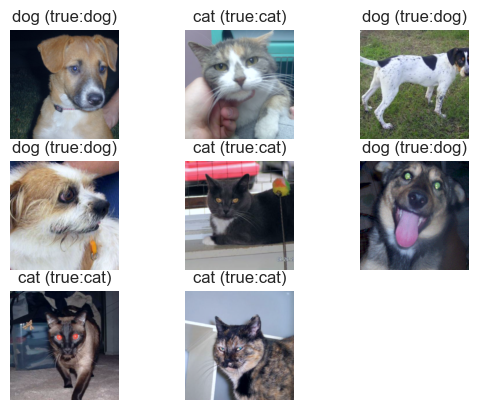

In [8]:
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    pred = model_ft(images)
    _, predicted = torch.max(pred.data, 1);

figure = plt.figure()
num_of_images = min(batch_size, 9)

for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title(f"Ground Truth: {classes[labels[index]]}")
    plt.title(f"{classes[predicted[index].item()]} (true:{classes[labels[index]]})")
    plt.imshow(np.transpose((images[index] * 0.224  + 0.456).cpu().numpy().squeeze(), (1, 2, 0)))  # 출력을 위한 차원변환 (channels*rows*cols) -> (rows*cols*channels)

Plot heatmap (confusion matrix)

      cat   dog
cat  3544   205
dog    71  3677


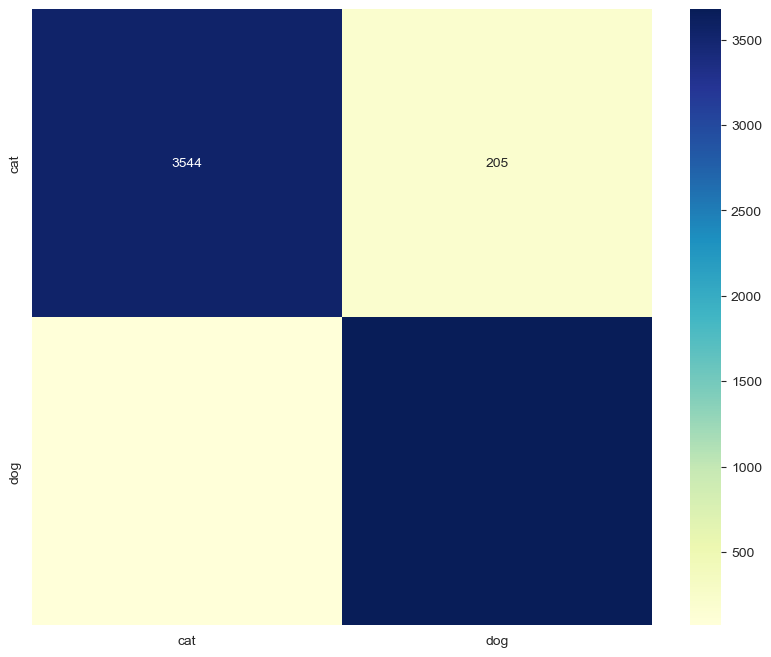

In [9]:
# Get some random test  images // BatchSize at a time
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)

for images, labels in test_dataloader:
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label, predicted_label] += 1
print(heatmap)
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

# Saving Models
* save the structure of this class together with the model

In [10]:
torch.save(model_ft, f"{model_name}_ft(hymenoptera).pth")